# First Test Basic VaR Models 

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np

# Import functions
import basic_var 
import backtesting as BT
import plots
import expected_shortfall as ES
import data_download as dd

### Data

In [18]:
# Download data
sp500_data = yf.download("^GSPC", start="2000-01-01", end="2024-01-01")
sp500_data["Log Returns"] = np.log(sp500_data["Close"] / sp500_data["Close"].shift(1))
returns = sp500_data["Log Returns"].dropna()

[*********************100%***********************]  1 of 1 completed


In [19]:
# Set parameters
confidence_level = 0.99 # <----- Can choose 0.95 etc

### Historical VaR

In [20]:
# Apply Historical VaR model
historical_output, var = basic_var.var_historical(returns, confidence_level)

print(f"Historical VaR estimate (abs): {var:.2f}%")

historical_output.head()

Historical VaR estimate (abs): 3.50%


,Returns,VaR,VaR Violation
Date,,,
2000-01-04,-0.039099,0.035011,True
2000-01-05,0.001920,0.035011,False
2000-01-06,0.000955,0.035011,False
2000-01-07,0.026730,0.035011,False
2000-01-10,0.011128,0.035011,False


Historical ES estimate (abs): 5.12%



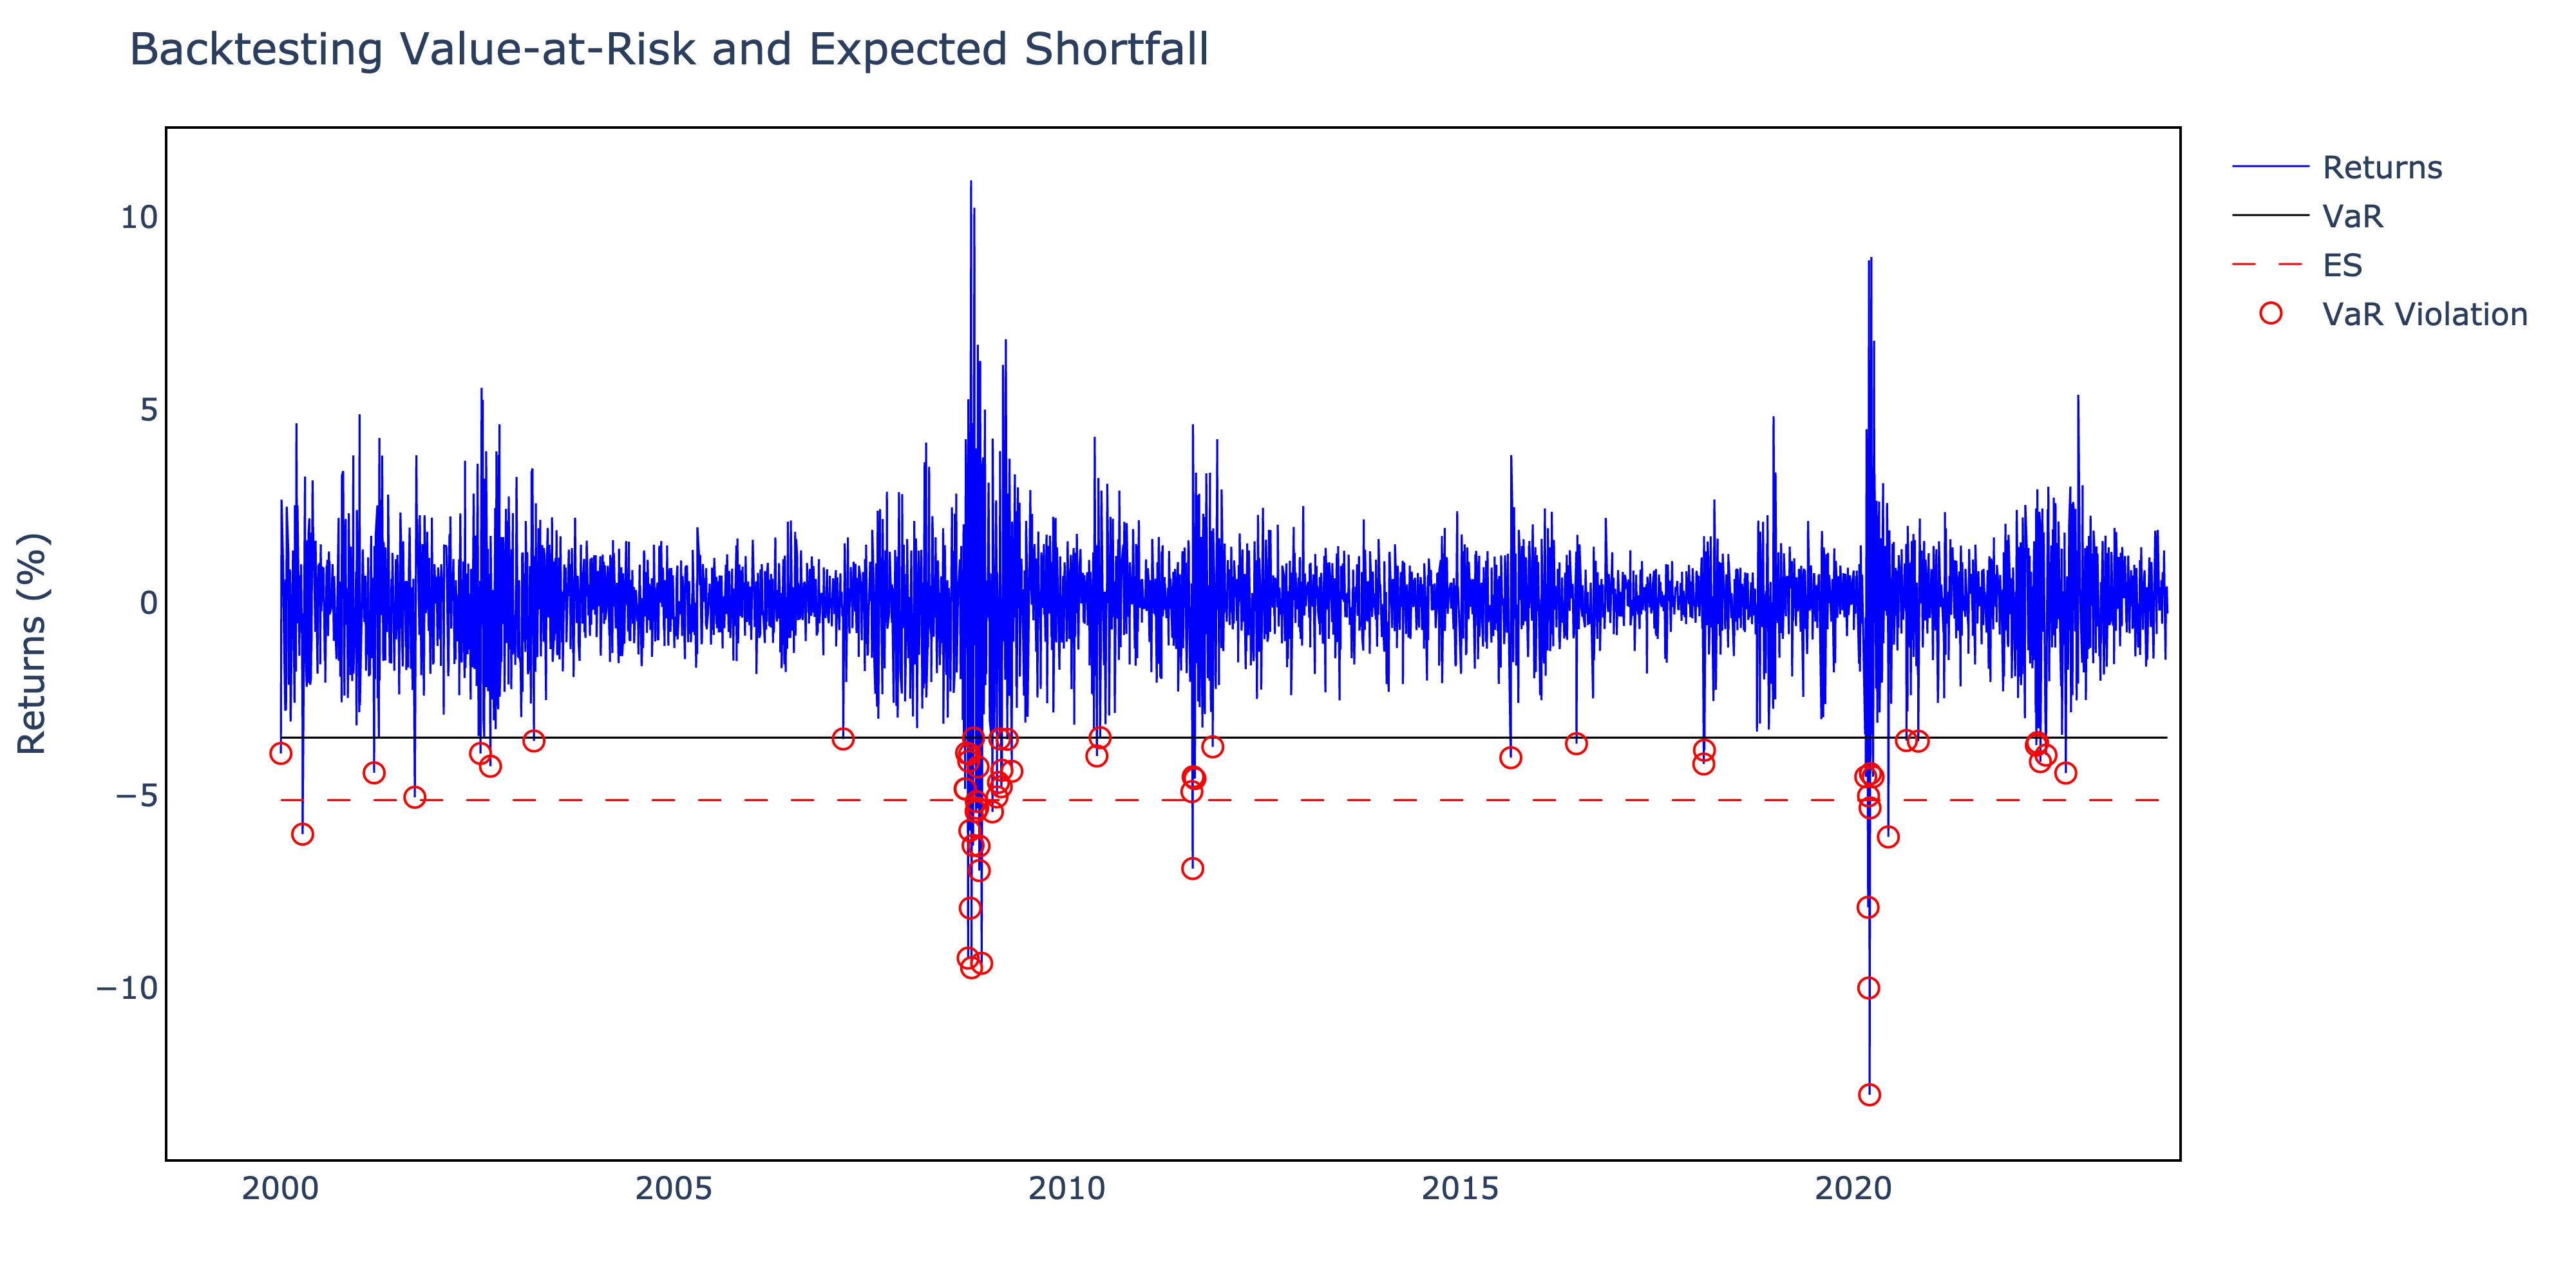

In [21]:
# Compute ES for the whole period
historical_output, es_estimate = ES.es_historical(historical_output)

print(f"Historical ES estimate (abs): {100 * es_estimate:.2f}%")

# Plot interactive VaR
fig_var = plots.plot_backtest(historical_output, interactive=False)


In [22]:
historical_output.head()

,Returns,VaR,VaR Violation,ES
Date,,,,
2000-01-04,-0.039099,0.035011,True,0.051204
2000-01-05,0.001920,0.035011,False,0.051204
2000-01-06,0.000955,0.035011,False,0.051204
2000-01-07,0.026730,0.035011,False,0.051204
2000-01-10,0.011128,0.035011,False,0.051204


### Parametric VaR

Parametric VaR estimate (abs): 3.63%
Parametric ES estimate (abs): 5.98%



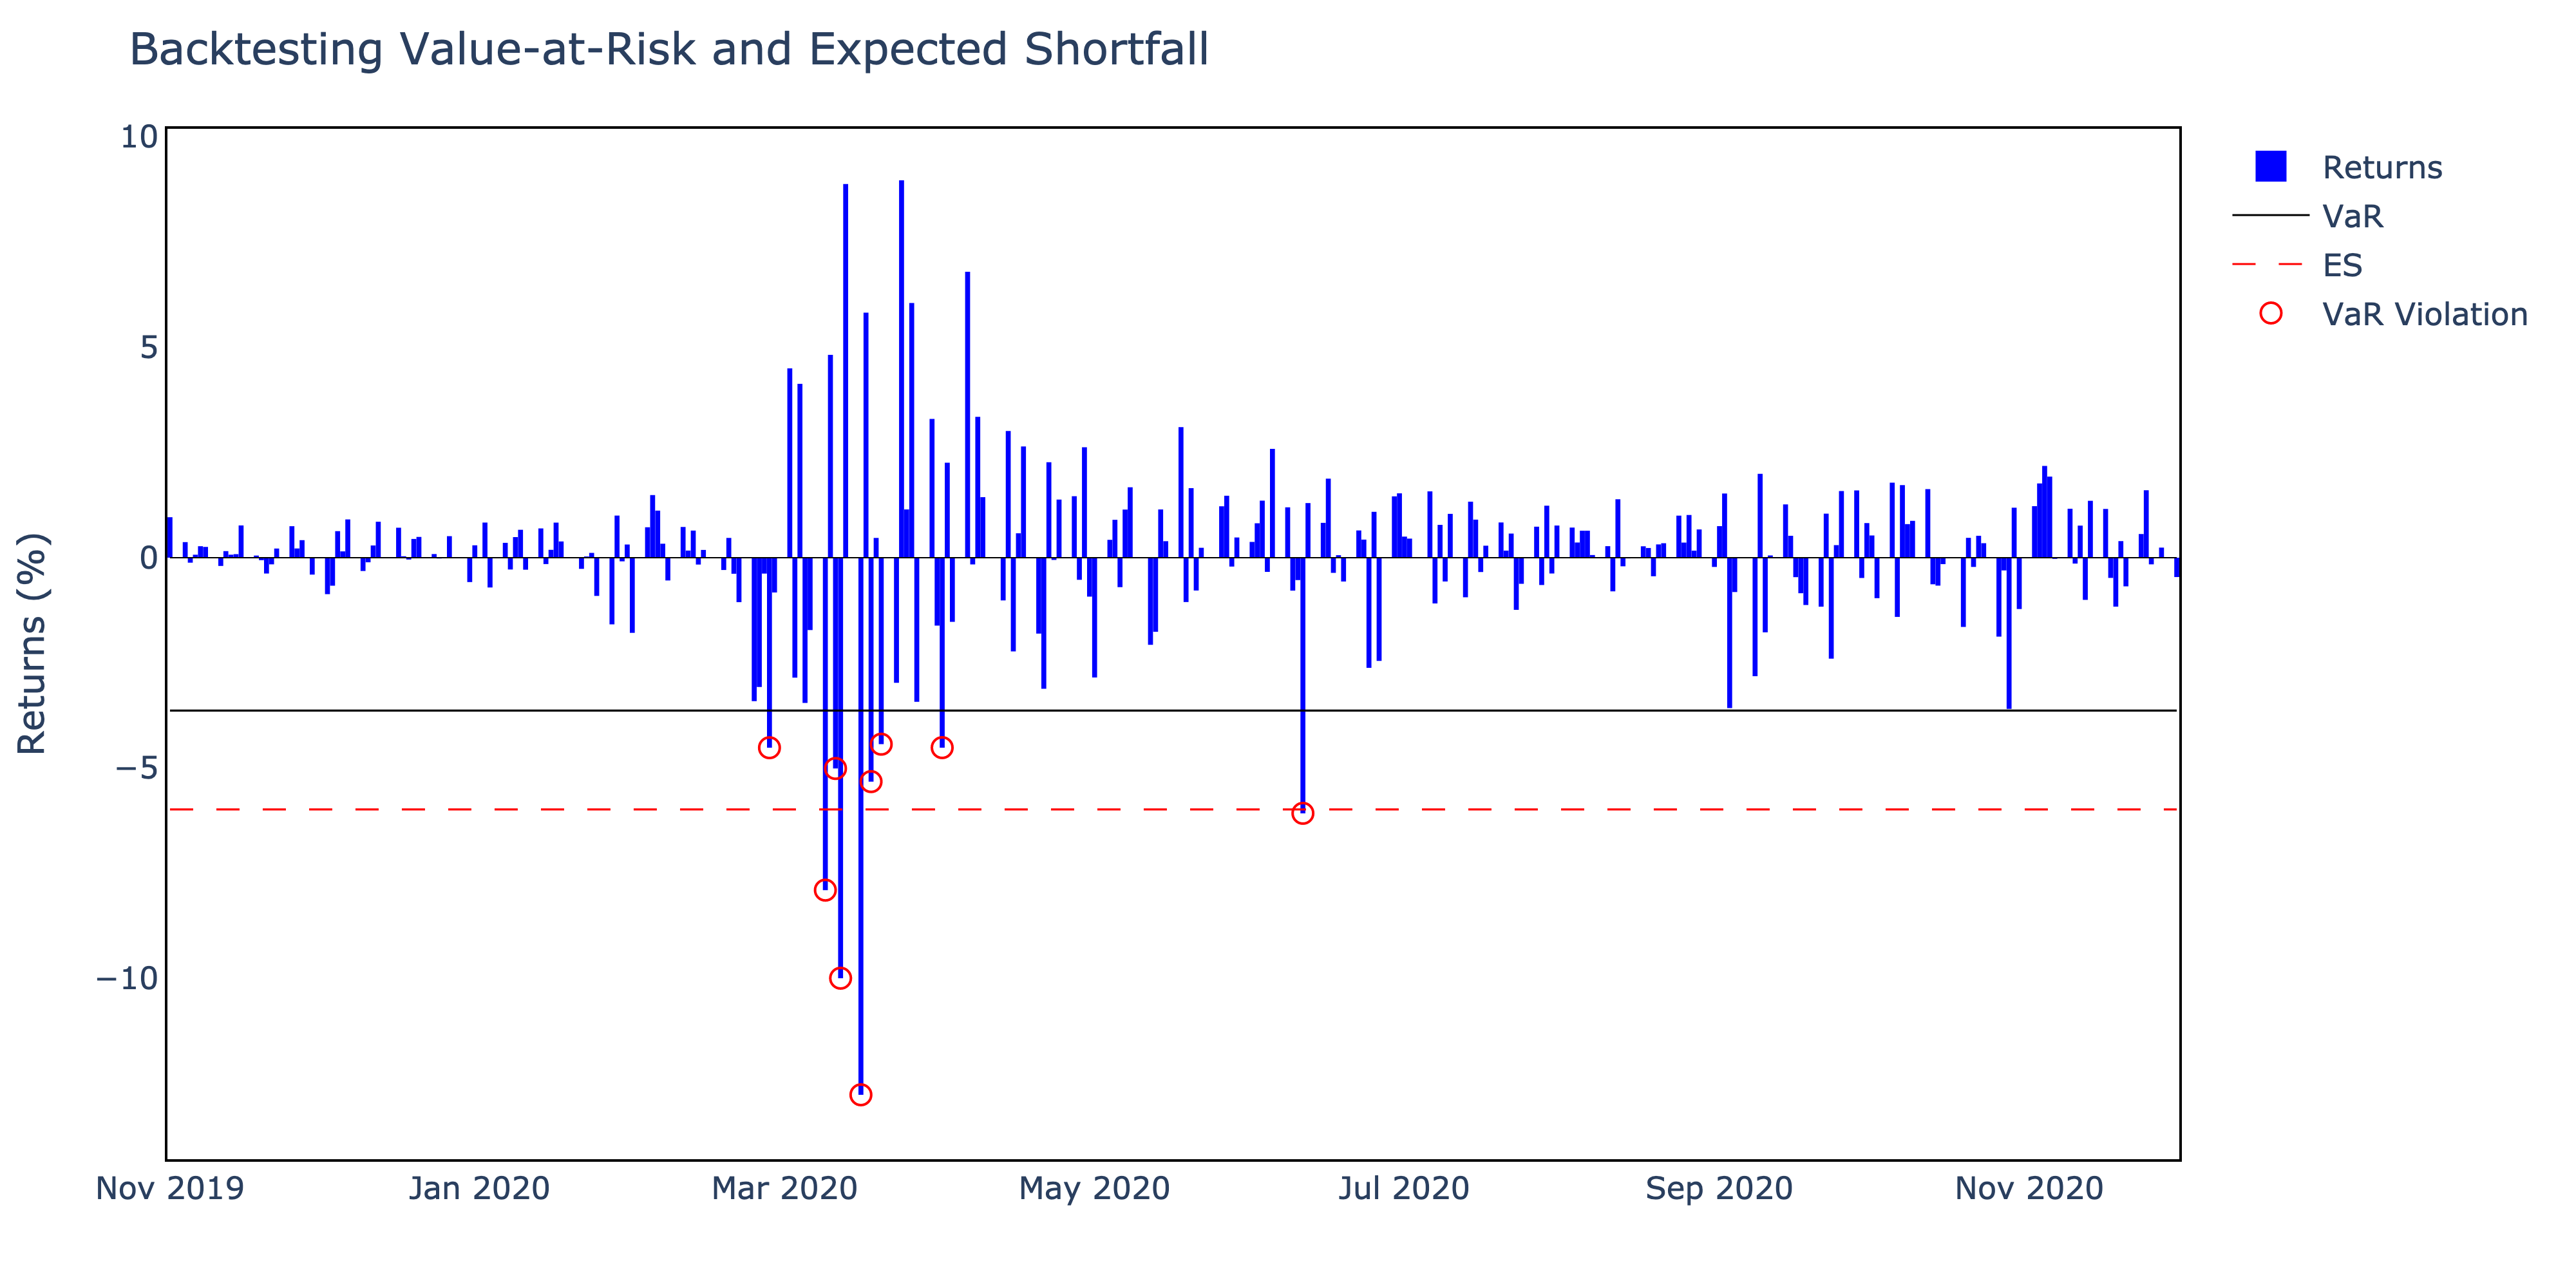

In [23]:
# Apply Parametric VaR model (choose distribution: "normal", "t", or "ged")
param_output, var = basic_var.var_parametric(returns, confidence_level, distribution="t")

print(f"Parametric VaR estimate (abs): {var:.2f}%")

# Compute ES for the whole period
param_output, es_estimate = ES.es_parametric(param_output, returns, confidence_level, distribution="t")

print(f"Parametric ES estimate (abs): {100 * es_estimate:.2f}%")


# Plot interactive VaR and ES for a subset
fig_es = plots.plot_backtest(param_output, subset=("2019-11-01", "2020-11-30"), interactive=False)


### Test Wealth Input

In [24]:
# Apply Parametric VaR model (choose distribution: "normal", "t", or "ged")
param_output_wealth, var_wealth = basic_var.var_parametric(returns, confidence_level, distribution="t", wealth=100000)

print(f"Parametric VaR estimate $ (abs): {var_wealth:.2f}")

param_output_wealth.head()

Parametric VaR estimate $ (abs): 3633.29


,Returns,VaR,VaR Violation,VaR_monetary
Date,,,,
2000-01-04,-0.039099,0.036333,True,3633.291494
2000-01-05,0.001920,0.036333,False,3633.291494
2000-01-06,0.000955,0.036333,False,3633.291494
2000-01-07,0.026730,0.036333,False,3633.291494
2000-01-10,0.011128,0.036333,False,3633.291494


In [25]:
# Compute ES for the whole period
param_output_es_wealth, es_estimate_wealth = ES.es_parametric(param_output, returns, confidence_level, distribution="t", wealth=100000)

print(f"Parametric ES estimate $ (abs): {es_estimate_wealth:.2f}")

param_output_es_wealth.head()   

Parametric ES estimate $ (abs): 5984.46


,Returns,VaR,VaR Violation,ES,ES_monetary
Date,,,,,
2000-01-04,-0.039099,0.036333,True,0.059845,5984.455465
2000-01-05,0.001920,0.036333,False,0.059845,5984.455465
2000-01-06,0.000955,0.036333,False,0.059845,5984.455465
2000-01-07,0.026730,0.036333,False,0.059845,5984.455465
2000-01-10,0.011128,0.036333,False,0.059845,5984.455465


### Backtesting

In [26]:
total_violations, violation_rate = BT.count_violations(param_output)

print(f"Total VaR Violations: {total_violations}")
print(f"Violation Rate: {violation_rate:.2f}%")


Total VaR Violations: 52
Violation Rate: 0.86%


In [27]:
kupiec_results = BT.kupiec_test(
    total_violations=total_violations,
    total_days=len(param_output),
    confidence_level=confidence_level
)

print("\nKupiec Test Results:")
for key, value in kupiec_results.items():
    print(f"{key}: {value}")


Kupiec Test Results:
LR_uc: 1.2270671079637623
p_value: 0.267978174864395
reject_null: False


In [28]:
christoffersen_results = BT.christoffersen_test(param_output)

print("\nChristoffersen Test Results:")
for key, value in christoffersen_results.items():
    print(f"{key}: {value}")



Christoffersen Test Results:
LR_c: 11.058044131520774
p_value: 0.0008830324465580741
reject_null: True


In [29]:
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)

print("\nJoint Test Results:")
for key, value in joint_results.items():
    print(f"{key}: {value}")


Joint Test Results:
LR_total: 12.285111239484536
p_value: 0.002149423484074986
reject_null: True


### Appendix (DOUBLE CHECK)

#### 1. Historical Expected Shortfall (Tail Mean)  
Historical ES is the average of losses that exceed the historical VaR threshold.

$$
\text{ES} = -\mathbb{E}[r_t \mid r_t < -\text{VaR}_\alpha]
$$

#### 2. Parametric Expected Shortfall (Normal or Student-t)  
For the Normal distribution, the ES has a closed-form solution:

$$
\text{ES}_{\text{normal}} = \sigma \cdot \frac{\phi(z_\alpha)}{1 - \alpha}
$$

For the Student-t distribution with $\nu$ degrees of freedom:

$$
\text{ES}_{t} = \sigma \cdot \frac{f_{t_\nu}(t_\alpha)}{1 - \alpha} \cdot \frac{\nu + t_\alpha^2}{\nu - 1}
$$

Where:  
- $z_\alpha$ is the quantile from the standard Normal distribution  
- $t_\alpha$ is the quantile from the Student-t distribution  
- $\phi$ is the PDF of the standard Normal  
- $f_{t_\nu}$ is the PDF of the t-distribution  
- $\sigma$ is the standard deviation or scale parameter
